In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

data = pd.read_csv('train.csv', nrows=50000)

In [2]:
data.head(3)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2


In [3]:
data = data.query('pickup_latitude > 40.7 and pickup_latitude < 40.8 and ' +
                  'dropoff_latitude > 40.7 and dropoff_latitude < 40.8 and ' +
                  'pickup_longitude > -74 and pickup_longitude < -73.9 and ' +
                  'dropoff_longitude > -74 and dropoff_longitude < -73.9 and ' +
                  'fare_amount > 0'
                  )

y = data.fare_amount

In [4]:
base_features = ['pickup_longitude',
                 'pickup_latitude',
                 'dropoff_longitude',
                 'dropoff_latitude']

X = data[base_features]

In [5]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
first_model = RandomForestRegressor(n_estimators=30, random_state=1).fit(train_X, train_y)

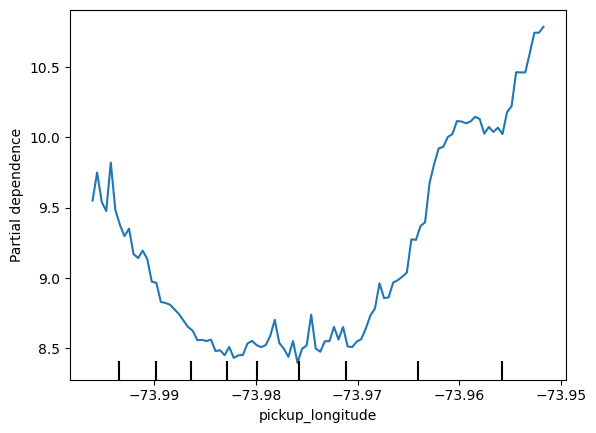

In [6]:
from matplotlib import pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

feat_name = 'pickup_longitude'
PartialDependenceDisplay.from_estimator(first_model, val_X, [feat_name])
plt.show()

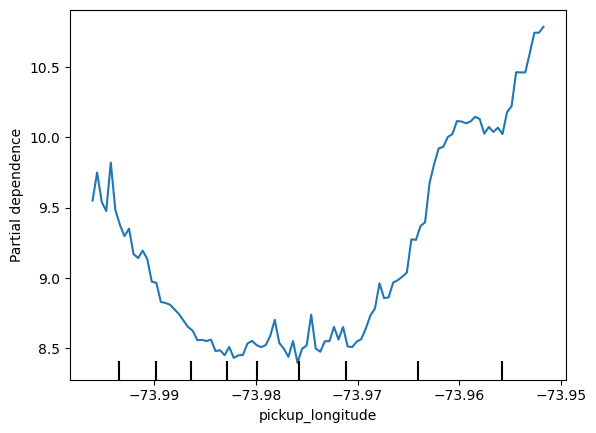

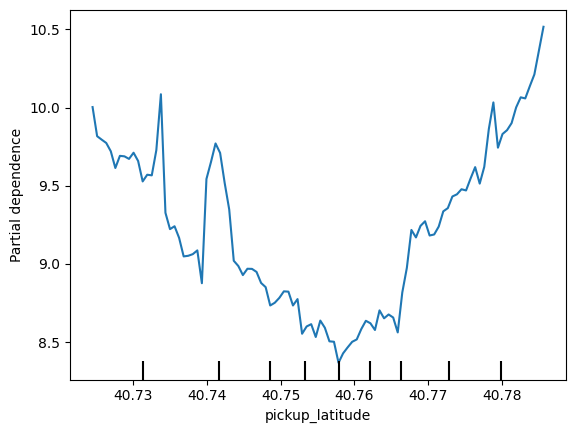

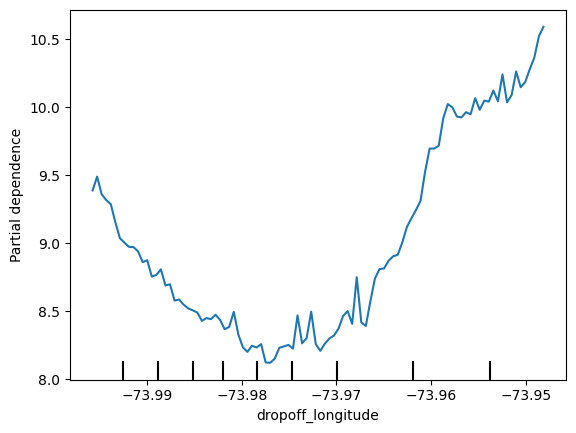

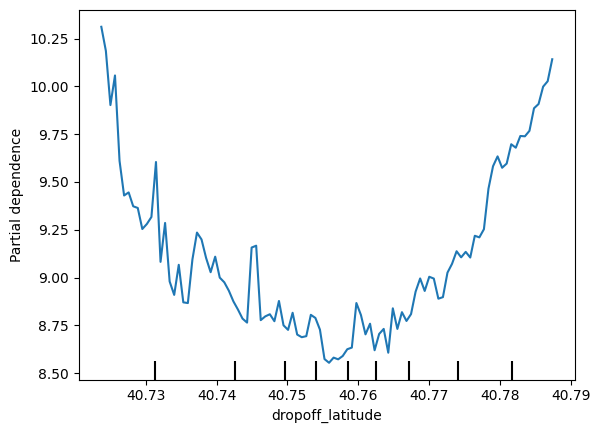

In [7]:
for feat_name in base_features:
    PartialDependenceDisplay.from_estimator(first_model, val_X, [feat_name])
    plt.show()

This model didn't include distance measures (like absolute change in latitude or longitude) as features, so coordinate features (like pickup_longitude) capture the effect of distance. Being picked up near the center of the longitude values lowers predicted fares on average, because it means shorter trips (on average).

For the same reason, we see the general U-shape in all our partial dependence plots.

### Question 2


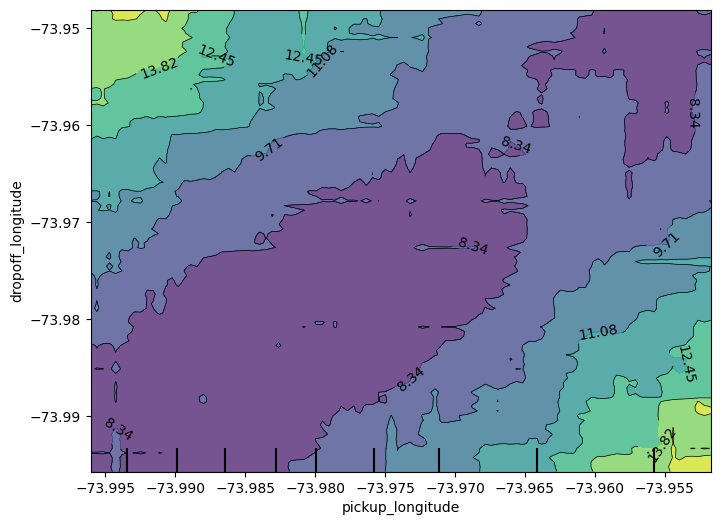

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
f_names = [('pickup_longitude', 'dropoff_longitude')]
PartialDependenceDisplay.from_estimator(first_model, val_X, f_names, ax=ax)
plt.show()

We expect the diagonal contours because these are pairs of values where the pickup and dropoff longitudes are nearby, indicating shorter trips (controlling for other factors).

As you get further from the central diagonal, we should expect prices to increase as the distances between the pickup and dropoff longitudes also increase.

The surprising feature is that prices increase as you go further to the upper-right of this graph, even staying near that 45-degree line.

This could be worth further investigation, though the effect of moving to the upper right of this graph is small compared to moving away from that 45-degree line.

### Question 3

Consider a ride starting at longitude -73.955 and ending at longitude -74. Using the graph from the last question, estimate how much money the rider would have saved if they'd started the ride at longitude -73.98 instead.

About 6. The price decreases from slightly less than 15 to slightly less than 9.

### Question 4

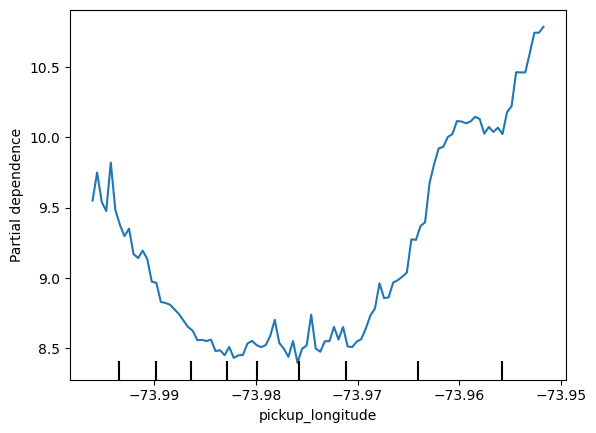

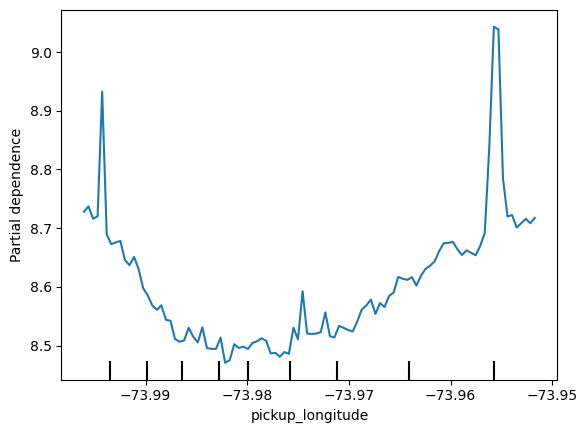

In [9]:
# This is the PDP for pickup_longitude without the absolute difference features. Included here to help compare it to the new PDP you create
feat_name = 'pickup_longitude'
PartialDependenceDisplay.from_estimator(first_model, val_X, [feat_name])
plt.show()

# create new features
data['abs_lon_change'] = abs(data.dropoff_longitude - data.pickup_longitude)
data['abs_lat_change'] = abs(data.dropoff_latitude - data.pickup_latitude)

features_2  = ['pickup_longitude',
               'pickup_latitude',
               'dropoff_longitude',
               'dropoff_latitude',
               'abs_lat_change',
               'abs_lon_change']

X = data[features_2]
new_train_X, new_val_X, new_train_y, new_val_y = train_test_split(X, y, random_state=1)
second_model = RandomForestRegressor(n_estimators=30, random_state=1).fit(new_train_X, new_train_y)

feat_name = 'pickup_longitude'
disp = PartialDependenceDisplay.from_estimator(second_model, new_val_X, [feat_name])
plt.show()

In the PDP's you've seen so far, location features have primarily served as a proxy to capture distance traveled. In the permutation importance lessons, you added the features abs_lon_change and abs_lat_change as a more direct measure of distance.

The difference is that the partial dependence plot became smaller. Both plots have a lowest vertical value of 8.5. But, the highest vertical value in the top chart is around 10.7, and the highest vertical value in the bottom chart is below 9.1. In other words, once you control for absolute distance traveled, the pickup_longitude has a smaller impact on predictions.

### Question 5

Consider a scenario where you have only 2 predictive features, which we will call feat_A and feat_B. Both features have minimum values of -1 and maximum values of 1. The partial dependence plot for feat_A increases steeply over its whole range, whereas the partial dependence plot for feature B increases at a slower rate (less steeply) over its whole range.

Does this guarantee that feat_A will have a higher permutation importance than feat_B. Why or why not?

No. This doesn't guarantee feat_a is more important. For example, feat_a could have a big effect in the cases where it varies, but could have a single value 99% of the time. In that case, permuting feat_a wouldn't matter much, since most values would be unchanged.

### Question 6

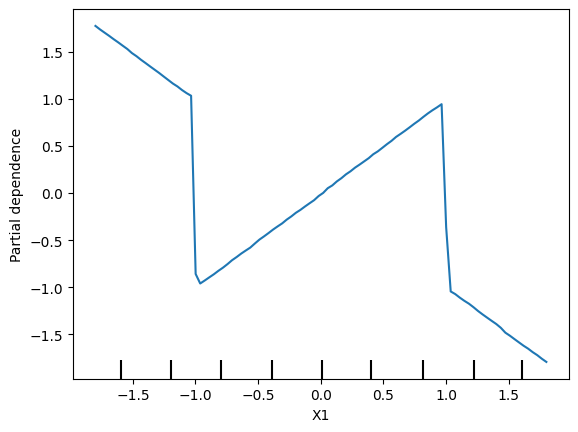

In [10]:
import numpy as np
from numpy.random import rand

n_samples = 20000

# Create array holding predictive feature
X1 = 4 * rand(n_samples) - 2
X2 = 4 * rand(n_samples) - 2

# Create y. you should have X1 and X2 in the expression for y
y = -2 * X1 * (X1<-1) + X1 - 2 * X1 * (X1>1) - X2

# create dataframe 
my_df = pd.DataFrame({'X1': X1, 'X2': X2, 'y': y})
predictors_df = my_df.drop(['y'], axis=1)

my_model = RandomForestRegressor(n_estimators=30, random_state=1).fit(predictors_df, my_df.y)
disp = PartialDependenceDisplay.from_estimator(my_model, predictors_df, ['X1'])
plt.show()


### Question 7

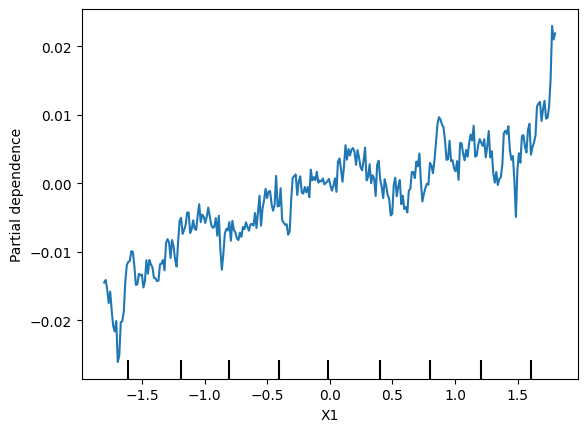

In [12]:
import eli5
from eli5.sklearn import PermutationImportance

n_samples = 20000

# Create array holding predictive feature
X1 = 4 * rand(n_samples) - 2
X2 = 4 * rand(n_samples) - 2
# Create y. you should have X in the expression for y
y = X1 * X2

# create dataframe because pdp_isolate expects a dataFrame as an argument
my_df = pd.DataFrame({'X1': X1, 'X2': X2, 'y': y})
predictors_df = my_df.drop(['y'], axis=1)

my_model = RandomForestRegressor(n_estimators=30, random_state=1).fit(predictors_df, my_df.y)


disp = PartialDependenceDisplay.from_estimator(my_model, predictors_df, ['X1'], grid_resolution=300)
plt.show()

perm = PermutationImportance(my_model).fit(predictors_df, my_df.y)

# show the weights for the permutation importance you just calculated
eli5.show_weights(perm, feature_names = ['X1', 'X2'])
